![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.3.ZeroShot_Clinical_Relation_Extraction.ipynb)

#Zero-Shot Clinical Relation Extraction Model

### Zero-shot Relation Extraction to extract relations between clinical entities with no training dataset
This release includes a zero-shot relation extraction model that leverages `BertForSequenceClassificaiton` to return, based on a predefined set of relation candidates (including no-relation / O), which one has the higher probability to be linking two entities.

The dataset will be a csv which contains the following columns: `sentence`, `chunk1`, `firstCharEnt1`, `lastCharEnt1`, `label1`, `chunk2`, `firstCharEnt2`, `lastCharEnt2`, `label2`, `rel`.

For example, let's take a look at this dataset (columns `chunk1`, `rel`, `chunk2` and `sentence`):

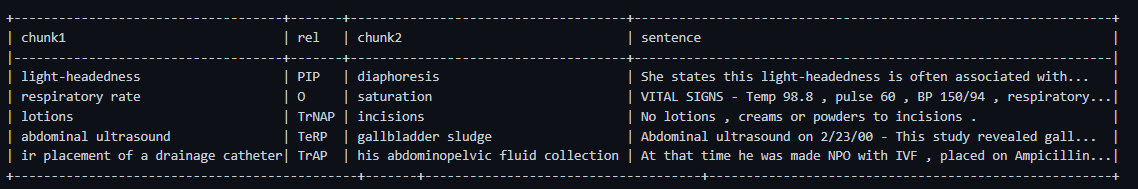


The relation types (TeRP, TrAP, PIP, TrNAP, etc...) are described [here](https://www.i2b2.org/NLP/Relations/assets/Relation%20Annotation%20Guideline.pdf)

Let's take a look at the first sentence!

`She states this light-headedness is often associated with shortness of breath and diaphoresis occasionally with nausea`

As we see in the table, the sentences includes a `PIP` relationship (`Medical problem indicates medical problem`), meaning that in that sentence, chunk1 (`light-headedness`) *indicates* chunk2 (`diaphoresis`).

We set a list of candidates tags (`[PIP, TrAP, TrNAP, TrWP, O]`) and candidate sentences (`[light-headedness caused diaphoresis, light-headedness was administered for diaphoresis, light-headedness was not given for diaphoresis, light-headedness worsened diaphoresis]`), meaning that:

- `PIP` is expressed by `light-headedness caused diaphoresis`
- `TrAP` is expressed by `light-headedness was administered for diaphoresis`
- `TrNAP` is expressed by `light-headedness was not given for diaphoresis`
- `TrWP` is expressed by `light-headedness worsened diaphoresis`
- or something generic, like `O` is expressed by `light-headedness and diaphoresis`...

We will get that the biggest probability of is `PIP`, since it's phrase `light-headedness caused diaphoresis` is the most similar relationship expressing the meaning in the original sentence (`light-headnedness is often associated with ... and diaphoresis`)

## Colab Setup

In [ ]:
import json
import os

from google.colab import files
license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Install display library
! pip -q install spark-nlp-display

In [3]:
# if you want to start the session with custom params as in start function above

from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")

    return builder.getOrCreate()

# spark = start(SECRET)

In [4]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *

from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark

Spark NLP Version : 5.0.0
Spark NLP_JSL Version : 5.0.0


## Zero Shot Relation Extraction
Using the pretrained `re_zeroshot_biobert` model, available in Models Hub under the Relation Extraction category.




In [5]:
# Clinical NER

documenter = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentencer = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = Tokenizer() \
    .setInputCols(["sentences"]) \
    .setOutputCol("tokens")

words_embedder = WordEmbeddingsModel() \
    .pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("embeddings")

ner_clinical = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens", "embeddings"]) \
    .setOutputCol("ner_clinical")

ner_clinical_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_clinical"]) \
    .setOutputCol("ner_clinical_chunks")\
    .setWhiteList(["PROBLEM", "TEST"])      # PROBLEM-TEST-TREATMENT

ner_posology = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens", "embeddings"]) \
    .setOutputCol("ner_posology")

ner_posology_converter = NerConverterInternal() \
    .setInputCols(["sentences", "tokens", "ner_posology"]) \
    .setOutputCol("ner_posology_chunks")\
    .setWhiteList(["DRUG"])                # DRUG-FREQUENCY-DOSAGE-DURATION-FORM-ROUTE-STRENGTH

chunk_merger = ChunkMergeApproach()\
    .setInputCols("ner_clinical_chunks", "ner_posology_chunks")\
    .setOutputCol('merged_ner_chunks')


## ZERO-SHOT RE Starting...

pos_tagger = PerceptronModel() \
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"]) \
    .setOutputCol("pos_tags")

dependency_parser = DependencyParserModel() \
    .pretrained("dependency_conllu", "en") \
    .setInputCols(["document", "pos_tags", "tokens"]) \
    .setOutputCol("dependencies")

re_ner_chunk_filter = RENerChunksFilter() \
    .setRelationPairs(["problem-test","problem-drug"]) \
    .setMaxSyntacticDistance(4)\
    .setDocLevelRelations(False)\
    .setInputCols(["merged_ner_chunks", "dependencies"]) \
    .setOutputCol("re_ner_chunks")

re_model = ZeroShotRelationExtractionModel.pretrained("re_zeroshot_biobert", "en", "clinical/models")\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")\
    .setRelationalCategories({
                            "ADE": ["{DRUG} causes {PROBLEM}."],
                            "IMPROVE": ["{DRUG} improves {PROBLEM}.", "{DRUG} cures {PROBLEM}."],
                            "REVEAL": ["{TEST} reveals {PROBLEM}."]})\
    .setMultiLabel(True)

pipeline = sparknlp.base.Pipeline() \
    .setStages([documenter,
                sentencer,
                tokenizer,
                words_embedder,
                ner_clinical,
                ner_clinical_converter,
                ner_posology,
                ner_posology_converter,
                chunk_merger,
                pos_tagger,
                dependency_parser,
                re_ner_chunk_filter,
                re_model])

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
[OK!]
ner_posology download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
re_zeroshot_biobert download started this may take some time.
[OK!]


In [6]:
re_model.getClasses()

['IMPROVE', 'ADE', 'REVEAL']

In [7]:
# create Spark DF

sample_text = "Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer."

data = spark.createDataFrame([[sample_text]]).toDF("text")
data.show(truncate=False)

+---------------------------------------------------------------------------------------+
|text                                                                                   |
+---------------------------------------------------------------------------------------+
|Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer.|
+---------------------------------------------------------------------------------------+



**Fit the model and transform it with the dataframe.**

In [8]:
model = pipeline.fit(data)
results = model.transform(data)

In [9]:
# relations output

results.selectExpr("explode(relations) as relation").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
# results in Spark DF

from pyspark.sql import functions as F

results.select(F.explode(F.arrays_zip("relations.metadata", "relations.result")).alias("cols"))\
       .select(F.expr("cols['0']['sentence']").alias("sentence"),
               F.expr("cols['0']['entity1_begin']").alias("entity1_begin"),
               F.expr("cols['0']['entity1_end']").alias("entity1_end"),
               F.expr("cols['0']['chunk1']").alias("chunk1"),
               F.expr("cols['0']['entity1']").alias("entity1"),
               F.expr("cols['0']['entity2_begin']").alias("entity2_begin"),
               F.expr("cols['0']['entity2_end']").alias("entity2_end"),
               F.expr("cols['0']['chunk2']").alias("chunk2"),
               F.expr("cols['0']['entity2']").alias("entity2"),
               F.expr("cols['0']['hypothesis']").alias("hypothesis"),
               F.expr("cols['0']['nli_prediction']").alias("nli_prediction"),
               F.expr("cols['1']").alias("relation"),
               F.expr("cols['0']['confidence']").alias("confidence"),
       ).show(truncate=70)

+--------+-------------+-----------+-----------+-------+-------------+-----------+--------+-------+------------------------------+--------------+--------+----------+
|sentence|entity1_begin|entity1_end|     chunk1|entity1|entity2_begin|entity2_end|  chunk2|entity2|                    hypothesis|nli_prediction|relation|confidence|
+--------+-------------+-----------+-----------+-------+-------------+-----------+--------+-------+------------------------------+--------------+--------+----------+
|       0|            0|         10|Paracetamol|   DRUG|           38|         45|sickness|PROBLEM|Paracetamol improves sickness.|        entail| IMPROVE|0.98819494|
|       0|            0|         10|Paracetamol|   DRUG|           26|         33|headache|PROBLEM|Paracetamol improves headache.|        entail| IMPROVE| 0.9929625|
|       1|           48|         58|An MRI test|   TEST|           80|         85|  cancer|PROBLEM|   An MRI test reveals cancer.|        entail|  REVEAL| 0.9760039|
+---

## LightPipeline

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.
Spark NLP LightPipelines are Spark ML pipelines converted into a single machine but the multi-threaded task, becoming more than 10x times faster for smaller amounts of data (small is relative, but 50k sentences are roughly a good maximum). To use them, we simply plug in a trained (fitted) pipeline and then annotate a plain text. We don't even need to convert the input text to DataFrame in order to feed it into a pipeline that's accepting DataFrame as an input in the first place. This feature would be quite useful when it comes to getting a prediction for a few lines of text from a trained ML model.


In [11]:
light_model = LightPipeline(model)

In [12]:
lp_results = light_model.fullAnnotate(sample_text)

**RE Results with LP Function**

Lets create function to get the results in a pandas dataframe.

In [13]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.metadata['sentence'],
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'],
          rel.metadata['entity1'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'],
          rel.metadata['entity2'],
          rel.metadata['hypothesis'],
          rel.metadata['nli_prediction'],
          rel.result,
          rel.metadata['confidence'],
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['sentence', 'entity1_begin','entity1_end','chunk1','entity1','entity2_begin','entity2_end','chunk2', 'entity2','hypothesis', 'nli_prediction', 'relation', 'confidence'])

  return rel_df

In [14]:
rel_df = get_relations_df(lp_results)

print(sample_text, "\n\n")
rel_df

Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer. 




sentence entity1_begin entity1_end       chunk1 entity1 entity2_begin  \
0        0             0          10  Paracetamol    DRUG            38   
1        0             0          10  Paracetamol    DRUG            26   
2        1            48          58  An MRI test    TEST            80   

  entity2_end    chunk2  entity2                      hypothesis  \
0          45  sickness  PROBLEM  Paracetamol improves sickness.   
1          33  headache  PROBLEM  Paracetamol improves headache.   
2          85    cancer  PROBLEM     An MRI test reveals cancer.   

  nli_prediction relation  confidence  
0         entail  IMPROVE  0.98819494  
1         entail  IMPROVE   0.9929625  
2         entail   REVEAL   0.9760039

**As you can see, the results of LP are the same with Spark DF.**

## Visualization of Extracted Relations

We use `RelationExtractionVisualizer` method of `spark-nlp-display` library for visualization fo the extracted relations between the entities.

In [15]:
from sparknlp_display import RelationExtractionVisualizer


vis = RelationExtractionVisualizer()
vis.display(lp_results[0], 'relations', show_relations=True)

In [16]:
# another example

sample_text2 = "After taking Lipitor, I experienced fatigue and anxiety."

lp_results2 = light_model.fullAnnotate(sample_text2)
vis.display(lp_results2[0], 'relations', show_relations=True)

## Negative Relationship

**The Implementation Of A Negative Label Feature For Increased Accuracy In The Zero Shot Relation Extraction Model**


`setNegativeRelationships` parameter to the `ZeroShotRelationExtractionModel` annotator, empowering users to exercise more effective control over the model’s predictions for enhanced accuracy. This innovative parameter generates negative examples of relations and subsequently removes them, resulting in improved precision for positive labels.

This advanced feature demonstrates our ongoing commitment to delivering state-of-the-art solutions for healthcare professionals and researchers, facilitating more accurate analysis of complex relationships within clinical text and ultimately contributing to better patient care and outcomes.


In [17]:
re_model = ZeroShotRelationExtractionModel.pretrained("re_zeroshot_biobert", "en", "clinical/models")\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")\
    .setRelationalCategories({
                            "ADE": ["{DRUG} causes {PROBLEM}."],
                            "IMPROVE": ["{DRUG} improves {PROBLEM}.",
                                        "{DRUG} cures {PROBLEM}."],
                            "REVEAL": ["{TEST} reveals {PROBLEM}."]})\
    .setMultiLabel(True)\
    .setNegativeRelationships(["IMPROVE"])


pipeline = sparknlp.base.Pipeline() \
    .setStages([documenter,
                sentencer,
                tokenizer,
                words_embedder,
                ner_clinical,
                ner_clinical_converter,
                ner_posology,
                ner_posology_converter,
                chunk_merger,
                pos_tagger,
                dependency_parser,
                re_ner_chunk_filter,
                re_model])

re_zeroshot_biobert download started this may take some time.
[OK!]


In [18]:
# create Spark DF

sample_text = "Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer."

data = spark.createDataFrame([[sample_text]]).toDF("text")
data.show(truncate=False)

+---------------------------------------------------------------------------------------+
|text                                                                                   |
+---------------------------------------------------------------------------------------+
|Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer.|
+---------------------------------------------------------------------------------------+



In [19]:
model = pipeline.fit(data)
results = model.transform(data)

In [20]:
# relations output

results.selectExpr("explode(relations) as relation").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [21]:
light_model = LightPipeline(model)

lp_results = light_model.fullAnnotate(sample_text)

In [22]:
rel_df = get_relations_df(lp_results)

print(sample_text, "\n\n")
rel_df

Paracetamol can alleviate headache or sickness. An MRI test can be used to find cancer. 




sentence entity1_begin entity1_end       chunk1 entity1 entity2_begin  \
0        1            48          58  An MRI test    TEST            80   

  entity2_end  chunk2  entity2                   hypothesis nli_prediction  \
0          85  cancer  PROBLEM  An MRI test reveals cancer.         entail   

  relation confidence  
0   REVEAL  0.9760039

In [23]:
from sparknlp_display import RelationExtractionVisualizer


vis = RelationExtractionVisualizer()
vis.display(lp_results[0], 'relations', show_relations=True)

 - Without Setting setNegativeRelationships:

|sentence|entity1_begin|entity1_end|chunk1|entity1|entity2_begin|entity2_end|chunk2|entity2|hypothesis|nli_prediction|relation|confidence|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|0|0|10|Paracetamol|DRUG|38|45|sickness|PROBLEM|Paracetamol improves sickness.|entail|IMPROVE|0.98819494|
|0|0|10|Paracetamol|DRUG|26|33|headache|PROBLEM|Paracetamol improves headache.|entail|IMPROVE|0.9929625|
|1|48|58|An MRI test|TEST|80|85|cancer|PROBLEM|An MRI test reveals cancer.|entail|REVEAL|0.9760039|




  - After Setting setNegativeRelationships:

|sentence|entity1_begin|entity1_end|chunk1|entity1|entity2_begin|entity2_end|chunk2|entity2|hypothesis|nli_prediction|relation|confidence|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1|48|58|An MRI test|TEST|80|85|cancer|PROBLEM|An MRI test reveals cancer.|entail|REVEAL|0.9760039|


# Save the Model and Load from Disc

After creating the Hypothesis, we can save the model and load it from disc without setting releatin categories.

In [24]:
# save model

re_model.write().overwrite().save("re_model")

In [25]:
# load from disc and create a new pipeline

re_model2 = ZeroShotRelationExtractionModel.load("re_model")\
    .setInputCols(["re_ner_chunks", "sentences"]) \
    .setOutputCol("relations")


pipeline2 = sparknlp.base.Pipeline() \
    .setStages([documenter,
                sentencer,
                tokenizer,
                words_embedder,
                ner_clinical,
                ner_clinical_converter,
                ner_posology,
                ner_posology_converter,
                chunk_merger,
                pos_tagger,
                dependency_parser,
                re_ner_chunk_filter,
                re_model2])

model2 = pipeline2.fit(data)
results2 = model2.transform(data)

In [26]:
re_model2.getClasses()

['IMPROVE', 'REVEAL', 'ADE']

In [27]:
# results of the new pipeline

results2.selectExpr("explode(relations) as relation").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|relation                                                                                                                                                                                                                                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

As you can see above, we got the same results by loading our saved ZSL model from disc although we didn't set any relation categories.